In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from pprint import pformat
import sympy as sp
import itertools
from scipy.stats import norm
from scipy.signal import fftconvolve
from scipy.integrate import trapz

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(10, 8), dpi=144)

In [4]:
sp.init_printing()

# The general 1-tagger case

In [5]:
dMs, Gs, dGs, t = sp.symbols('{\Delta{m_s}} {\Gamma_s} {\Delta{\Gamma_s}} t', real=True)
e, de, wa, dw, a, b = sp.symbols(' '.join([r'{\varepsilon}',
                                           r'{\Delta\varepsilon}',
                                           r'{\omega}',
                                           r'{\Delta\omega}',
                                           r'\alpha',
                                           r'\beta',]), real=True)
d = sp.symbols('d', integer=True)

In [6]:
w = wa + dw / 2
wb = wa - dw / 2

In [7]:
physical_params = {
    dMs: 17.8,
    dGs: 0.085,
    Gs: 0.66,
}

In [8]:
CeffCoshP = (1 + b) * (e - d * de / 2 - d * a *
                       (e - d * de / 2 - e * (w + wb) + de / 2 *
                        (w - wb)) - d * e * (w - wb) + d * de / 2 * (w + wb))
CeffCoshM = (1 - b) * (e - d * de / 2 - d * a *
                       (e - d * de / 2 - e * (w + wb) + de / 2 *
                        (w - wb)) - d * e * (w - wb) + d * de / 2 * (w + wb))
CeffCoshMU = (1 - b) * (2 * (1 - e) - a * de)
CeffCoshPU = (1 + b) * (2 * (1 - e) - a * de)
CeffCosM = (1 - b) * (d * e - de / 2 - a *
                      (e - d * de / 2 - d * e * (w - wb) + d * de / 2 *
                       (w + wb)) - d * e * (w + wb) + d * de / 2 * (w - wb))
CeffCosP = (1 + b) * (d * e - de / 2 - a *
                      (e - d * de / 2 - d * e * (w - wb) + d * de / 2 *
                       (w + wb)) - d * e * (w + wb) + d * de / 2 * (w - wb))
CeffCosMU = (1 - b) * (de - 2 * a * (1 - e))
CeffCosPU = (1 + b) * (de - 2 * a * (1 - e))

In [9]:
cos_t = sp.cos(dMs * t)
cosh_t = sp.cosh(dGs * t / 2)

In [10]:
CphysM, CphysU = sp.symbols(r'{C_\text{phys}^m} {C_\text{phys}^u}', real=True)

In [11]:
Cf, Cfb = sp.symbols(r'{C_{f}} {C_{\bar{f}}}')

In [12]:
# these are the "simple" decay rates, using only one tagger
# dec_MP refers to "negative" final state, (M)inus and "positive" initial state, (P)lus
dec_PP = (sp.exp(-Gs * t) * (CeffCoshP * cosh_t + Cf * CeffCosP * cos_t)).subs({d: 1})
dec_MP = (sp.exp(-Gs * t) * (CeffCoshP * cosh_t + Cfb * CeffCosP * cos_t)).subs({d: 1})
dec_PU = (sp.exp(-Gs * t) * (CeffCoshPU * cosh_t + Cf * CeffCosPU * cos_t))
dec_MM = (sp.exp(-Gs * t) * (CeffCoshM * cosh_t + Cfb * CeffCosM * cos_t)).subs({d: -1})
dec_PM = (sp.exp(-Gs * t) * (CeffCoshM * cosh_t + Cf * CeffCosM * cos_t)).subs({d: -1})
dec_MU = (sp.exp(-Gs * t) * (CeffCoshMU * cosh_t + Cfb * CeffCosMU * cos_t))

In [13]:
unmixed = dec_PP + dec_MM
mixed = dec_PM + dec_MP

In [14]:
asym = (unmixed - mixed) / (unmixed + mixed)

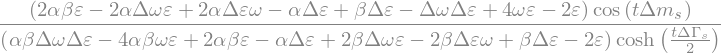

In [15]:
asym.subs({Cf:1,Cfb:-1}).simplify().collect([cos_t, cosh_t])

## Ignore any FT effects

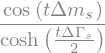

In [16]:
asym.subs({Cf:1,Cfb:-1,wa:0,e:1,de:0,dw:0}).simplify().collect([cos_t, cosh_t])

## Ignore production/detection asymmetries

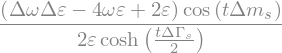

In [17]:
asym.subs({a:0,b:0,Cf:1,Cfb:-1}).simplify().collect([cos_t, cosh_t])

## A few plots...

In [18]:
unmixed_f = sp.lambdify(t, unmixed.subs({Cf:1,Cfb:-1,wa:0.3,e:0.8,de:0.001,dw:-0.01,dMs:17.8,dGs:0.085,Gs:0.66,a:-0.001,b:-0.01}).simplify().collect([cos_t, cosh_t]))
mixed_f = sp.lambdify(t, mixed.subs({Cf:1,Cfb:-1,wa:0.3,e:0.8,de:0.001,dw:-0.01,dMs:17.8,dGs:0.085,Gs:0.66,a:-0.001,b:-0.01}).simplify().collect([cos_t, cosh_t]))
asym_f = sp.lambdify(t, asym.subs({Cf:1,Cfb:-1,wa:0.3,e:0.8,de:0.001,dw:-0.01,dMs:17.8,dGs:0.085,a:-0.001,b:-0.01}).simplify().collect([cos_t, cosh_t]))

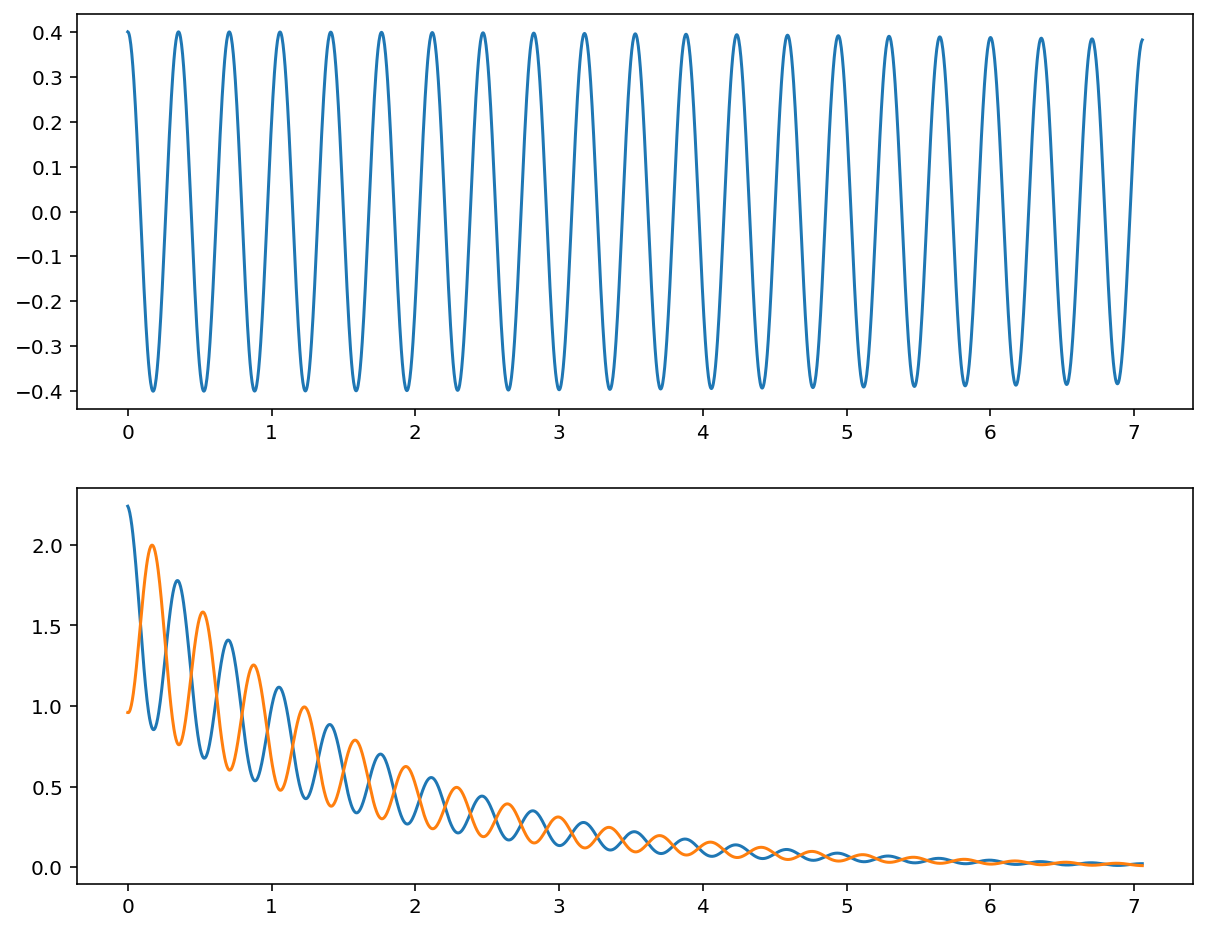

In [19]:
period = 2 * np.pi / 17.8
xs = np.concatenate([np.linspace(o * period, (o + 1) * period, 101)[:-1] for o in range(20)])
plt.subplot(211)
plt.plot(xs, asym_f(xs))
plt.subplot(212)
plt.plot(xs, unmixed_f(xs))
plt.plot(xs, mixed_f(xs))

## Numerically add a decay-time resolution
... via convolving with a gaussian function

In [20]:
def unmixed_f_res(xs, mean=0, scale=0.05, timedep=False):
    if timedep:
        resxs = np.array([norm.pdf(x, mean, scale * np.sqrt(x/2 + 1)) for x in xs])
    else:
        resxs = norm.pdf(xs, mean, scale)
    return fftconvolve(resxs, unmixed_f(xs), 'same')

def mixed_f_res(xs, mean=0, scale=0.05, timedep=False):
    if timedep:
        resxs = np.array([norm.pdf(x, mean, scale * np.sqrt(x/2 + 1)) for x in xs])
    else:
        resxs = norm.pdf(xs, mean, scale)
    return fftconvolve(resxs, mixed_f(xs), 'same')

def asym_res(xs, mean=0, scale=0.05):
    unmixed = unmixed_f_res(xs, mean, scale)
    mixed = mixed_f_res(xs, mean, scale)
    return (unmixed - mixed) / (unmixed + mixed)

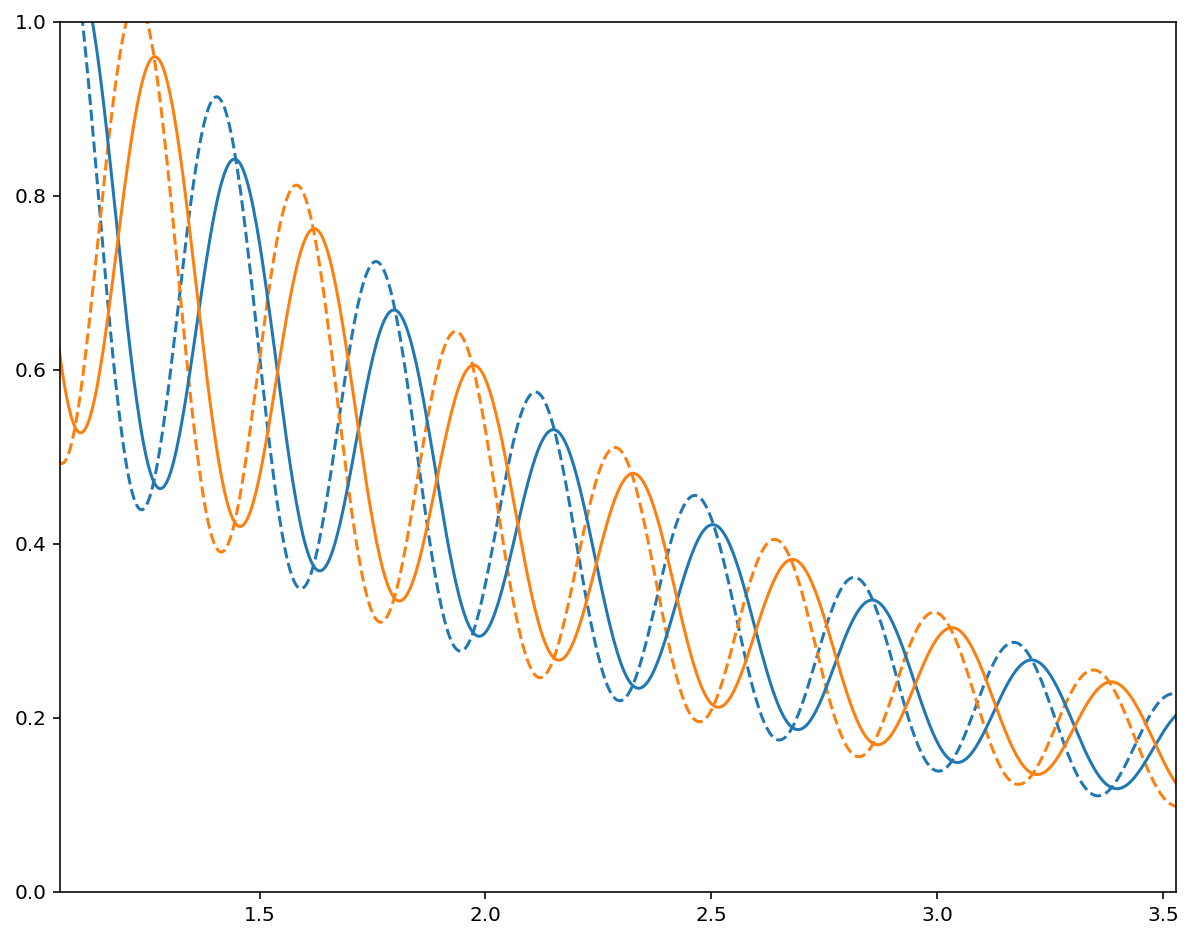

In [21]:
pmin = 3
pmax = 10
xlim = pmin * period, pmax * period
trange = (xs > xlim[0]) & (xs < xlim[1])

ys = unmixed_f(xs)
plt.plot(xs, ys / trapz(ys[trange], xs[trange]), 'C0--')
unmixed_mod = np.sum([ys[o * 100:(o+1)*100] for o in range(pmin, pmax)], axis=0)

ys = mixed_f(xs)
plt.plot(xs, ys / trapz(ys[trange], xs[trange]), 'C1--')
mixed_mod = np.sum([ys[o * 100:(o+1)*100] for o in range(pmin, pmax)], axis=0)

# need to correct for a shift induced by the fft convolution
ys = unmixed_f_res(xs, scale=0.049)
plt.plot(xs, ys / trapz(ys[trange], xs[trange]), 'C0')
unmixed_mod_res = np.sum([ys[o * 100:(o+1)*100] for o in range(pmin, pmax)], axis=0)

ys = mixed_f_res(xs, scale=0.049)
plt.plot(xs, ys / trapz(ys[trange], xs[trange]), 'C1')
mixed_mod_res = np.sum([ys[o * 100:(o+1)*100] for o in range(pmin, pmax)], axis=0)

plt.xlim(*xlim)
plt.ylim(0, 1)

0.8478113599314845 0.33840304509576996


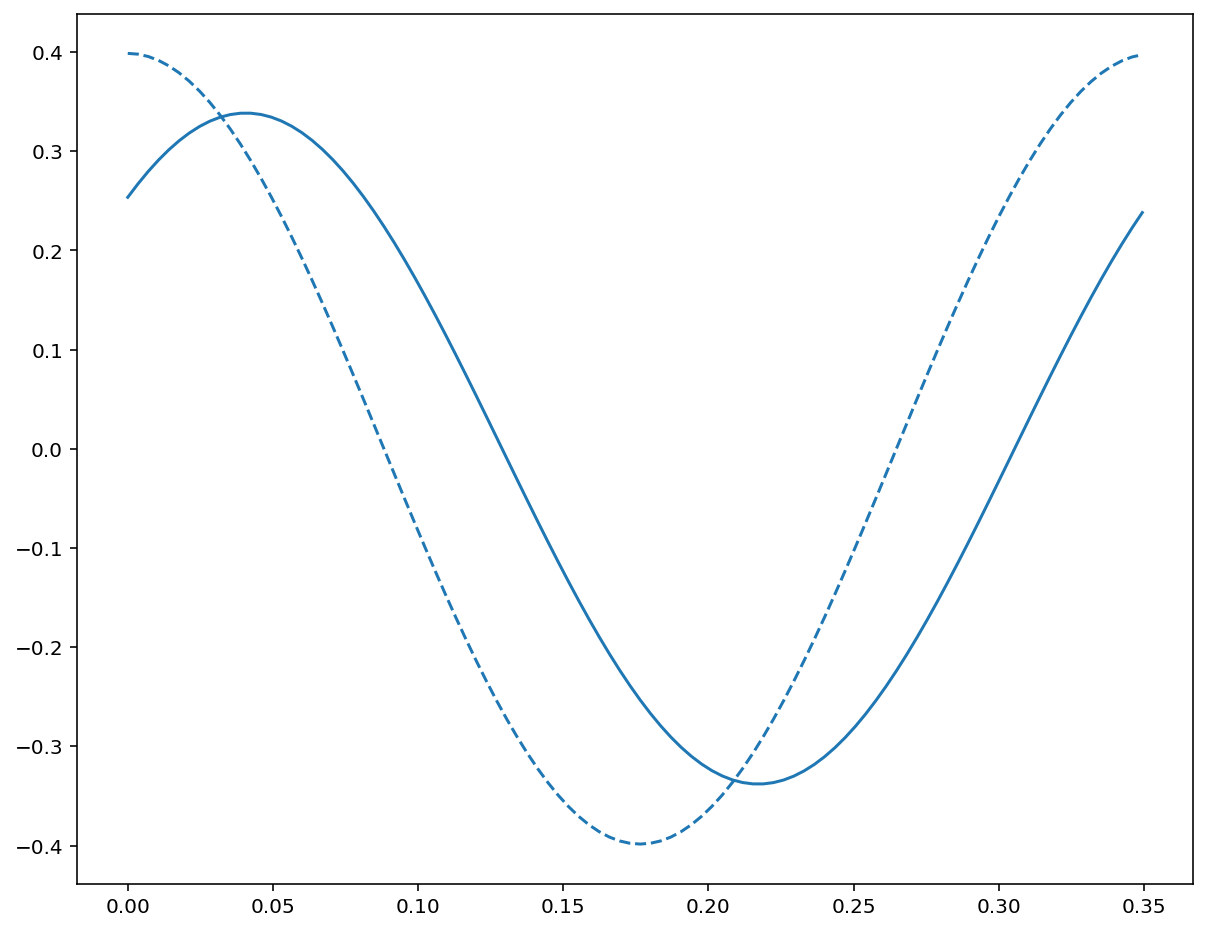

In [22]:
asym_mod_res = (unmixed_mod_res - mixed_mod_res) / (unmixed_mod_res + mixed_mod_res)
asym_mod = (unmixed_mod - mixed_mod) / (unmixed_mod + mixed_mod)
plt.plot(xs[:100], asym_mod, 'C0--')
plt.plot(xs[:100], asym_mod_res, 'C0')
print(asym_mod_res.min() / asym_mod.min(), asym_mod_res.max())

# Now the 2-tagger DecRateCoeff implementation

In [23]:
ei, ej, dei, dej = sp.symbols(r'{\varepsilon_i} {\varepsilon_j} {\Delta{\varepsilon_i}} {\Delta{\varepsilon_j}}', real=True)
wi, wj, dwi, dwj = sp.symbols(r'{\omega_i} {\omega_j} {\Delta{\omega_i}} {\Delta{\omega_j}}', real=True)
di, dj = sp.symbols(r'{d_i} {d_j}', integer=True)
ebi = ei - dei / 2
ebj = ej - dej / 2
ebbi = ei + dei / 2
ebbj = ej + dej / 2
wbi = wi - dwi / 2
wbj = wj - dwj / 2
wbbi = wi + dwi / 2
wbbj = wj + dwj / 2

In [24]:
# aka Delta Plus untagged untagged
DPuu = (1 - ebi - ebj + ebi * ebj) + (1 - ebbi - ebbj + ebbi * ebbj)
DMuu = (1 - ebi - ebj + ebi * ebj) - (1 - ebbi - ebbj + ebbi * ebbj)

In [25]:
DPtu = (1 / 2 * ebi * (1 - ebj + di * (1 - ebj - 2 * wbi + 2 * wbi * ebj))
        + 1 / 2 * ebbi * (1 - ebbj + di * (1 - ebbj - 2 * wbbi + 2 * wbbi * ebbj)))
DMtu = (1 / 2 * ebi * (1 - ebj + di * (1 - ebj - 2 * wbi + 2 * wbi * ebj))
        - 1 / 2 * ebbi * (1 - ebbj + di * (1 - ebbj - 2 * wbbi + 2 * wbbi * ebbj)))

In [26]:
DPtt = (1 / 4 * ebi * ebj * (1 + dj * (1 - 2 * wbj) + di * (1 - 2 * wbi)
                             + di * dj * (1 - 2 * wbj - 2*wbi + 4 * wbi * wbj))
      + 1 / 4 * ebbi * ebbj * (1 - dj * (1 - 2 * wbbj) - di * (1 - 2 * wbbi)
                             + di * dj * (1 - 2 * wbbj - 2*wbbi + 4 * wbbi * wbbj)))
DMtt = (1 / 4 * ebi * ebj * (1 + dj * (1 - 2 * wbj) + di * (1 - 2 * wbi)
                             + di * dj * (1 - 2 * wbj - 2*wbi + 4 * wbi * wbj))
      - 1 / 4 * ebbi * ebbj * (1 - dj * (1 - 2 * wbbj) - di * (1 - 2 * wbbi)
                             + di * dj * (1 - 2 * wbbj - 2*wbbi + 4 * wbbi * wbbj)))

In [27]:
DP = sp.Piecewise((DPuu, (di == 0) & (dj == 0)), (DPtu, (di == 0) != (dj == 0)), (DPtt, (di != 0) & (dj != 0)))
DM = sp.Piecewise((DMuu, (di == 0) & (dj == 0)), (DMtu, (di == 0) != (dj == 0)), (DMtt, (di != 0) & (dj != 0)))

In [28]:
q = sp.symbols('q', integer=True)
C2cos = q * (1 - q * a) * (DM - b * DP) #* sp.Piecewise((1, q==1), (-1, q==-1))
C2cosh = (1 + q * a) * (DP - b * DM)

In [29]:
dec = sp.exp(-Gs * t) * (C2cosh * cosh_t + C2cos * cos_t)

In [30]:
perfect_subs = {
    ei:1,
    ej:1,
    wi:0,
    wj:0,
    dei:0,
    dej:0,
    dwi:0,
    dwj:0,
    a:0,
    b:0,
}

In [31]:
realistic_subs = {
    ei:0.5,
    ej:0.8,
    wi:0.35,
    wj:0.4,
    dei:-0.01,
    dej:-0.01,
    dwi:-0.01,
    dwj:-0.01,
    a:-0.005,
    b:-0.005,
}

In [32]:
unmixed = sum([dec.subs({q:q_, di:di_, dj:dj_}) for q_, di_, dj_ in [(1, 1, 1), (-1, -1, -1), (-1, 0, -1), (-1, -1, 0), (1, 0, 1), (1, 1, 0)]])
mixed = sum([dec.subs({q:q_, di:di_, dj:dj_}) for q_, di_, dj_ in [(-1, 1, 1), (1, -1, -1), (1, 0, -1), (1, -1, 0), (-1, 0, 1), (-1, 1, 0)]])
asym = (unmixed - mixed) / (unmixed + mixed)

In [ ]:
asym.subs(perfect_subs | {a:a, b:b}).simplify()

In [ ]:
plt.axhline(0, ls='--', color='0.5')
xs = np.linspace(0, period, 1000)
for i, pars in enumerate([{}, {a:0.3,b:0.3}, {dei:0.3}]):
    fn = sp.lambdify(t, asym.subs(realistic_subs | pars | physical_params))
    ys = fn(xs)
    plt.plot(xs, ys, label=str(pars))
plt.legend()